# TP3 Visión Por Computadora 1

* Mauro Aguirregaray
* Fabricio Denardi

**Consideraciones generales**
1. Siempre que lo consideramos necesario, realizamos un tipado de las funciones como una explicación detallada.
2. Intentamos nomenclar siempre en inglés variables, métodos, clases etc, aunque para un mejor entendimiento los comentarios los hicimos en español.

In [134]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import os
import time
import copy

**Template Matching**

En este Trabajo Práctico se nos pide aplicar algoritmos de template matching, en este caso, para detectar el logotipo de *Coca-Cola* en diferentes imágenes.

Para la primera parte, debemos generar un método que permita obtener una detección del logo en cada imagen sin tener falsos positivos

## Detección en cada imagen

Primero visualicemos cada imagen a trabajar:

In [135]:
def get_files(dir:str):
    '''Obtener la lista de archivos del directorio dado. Importante: No incluye subdirectorios'''
    return [os.path.join(dir,f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]


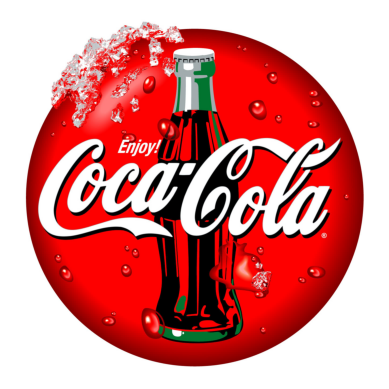

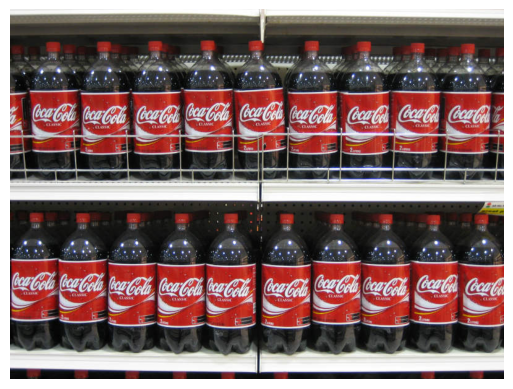

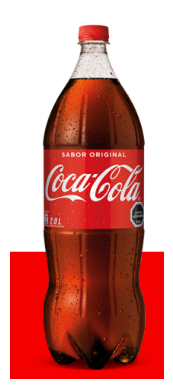

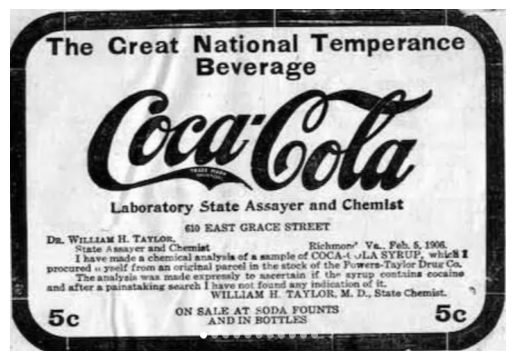

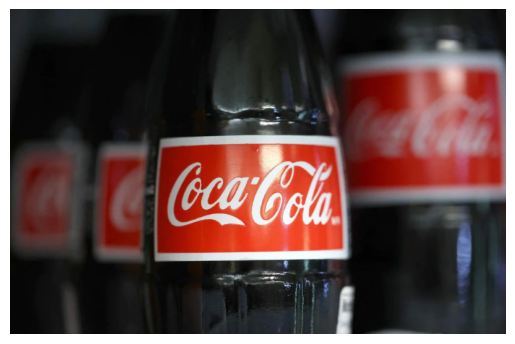

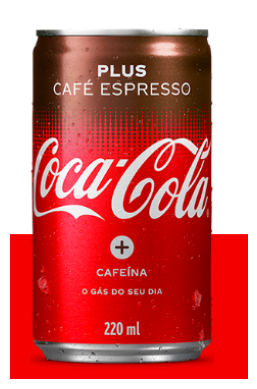

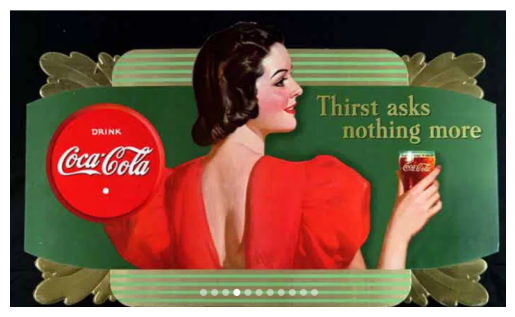

In [136]:
# Enumerar y mostrar las imágenes
image = []
for ix, image_path in enumerate(get_files('./images')):
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(image_rgb)
    plt.axis('off') 
    plt.show()

Varios comentarios podemos sacar de estas imágenes a tratar:

* Hay imágenes creadas digitalmente (las primeras tres), también hay otras que son fotografías y por último hay dos *vintage* que parecen salir de una especie de escaneo.
* Las que son fotografías presentan efectos de iluminación mientras que el resto no.
* Todos los logos son similares exceptuando el color en uno dónde se invierte.
* Las imágenes y sobretodo los logos tienen diferente tamaño en cada caso.
* Si bien el tamaño de las imágenes y los logos varían imagen a imagen, la proporcionalidad de las dimensiones del logo no varían (no hay un CocaCola alargado por ejemplo). Así que solo son modificaciones de escala.

Carguemos el template:

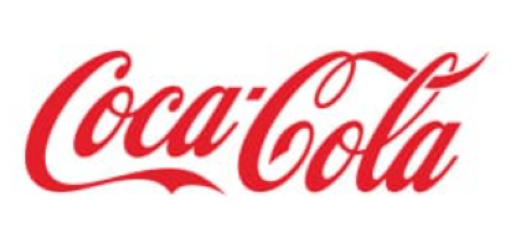

In [137]:
# Enumerar y mostrar las imágenes
image = []
for ix, image_path in enumerate(get_files('./template')):
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(image_rgb)
    plt.axis('off') 
    plt.show()

El template es una imagen creada digitalmente y los colores son diferentes a todos los casos anteriores.

Por lo tanto lo que vamos a tener que buscar matchear será la forma del logo y para eso deberemos de usar algún método para encontrar los bordes (Canny).

Otro punto a trabajar del logo es que tiene mucho espacio blanco que no aporta información relevante.

Además ya vimos antes que los logos en cada imagen tienen diferente escala, así que si buscamos un método que generalice su funcionalidad tendremos que iterar con diferentes escalas de logo de manera que en algún caso se parezca lo suficiente.

**Metodología para resolver la parte 1:**

1.  Tratamos el template para quedarnos solo con los bordes usando Canny.
2.  Mismo razonamiento para las imágenes donde detectaremos los logos.
3.  Iteramos para distintos tamaños de la imagen a buscar el logo.
4.  Nos quedamos con el mejor valor en cada caso y mostramos el nivel de confianza de la detección.

Generemos algunos métodos ahora para ir procesando las imágenes previamente a hacer el match:

In [138]:
# Procesamos la imagen del template
def prepare_template (pattern:np.ndarray, main_canny:bool = True, initial_resize:bool=False, remove_padding = False) -> np.ndarray:
    '''Prepara el template original para el procesamiento.  '''
    pattern = cv.cvtColor(pattern, cv.COLOR_BGR2GRAY)

   # Detectar todos los puntos que no son blancos
    if (remove_padding):
        non_white_points = np.where(pattern < 240)

        # Obtener las coordenadas del bounding box
        top_left = (np.min(non_white_points[1]), np.min(non_white_points[0]))
        bottom_right = (np.max(non_white_points[1]), np.max(non_white_points[0]))

        # Recortar la imagen al bounding box
        pattern = pattern[top_left[1]:bottom_right[1]+1, top_left[0]:bottom_right[0]+1]

    if (main_canny):
        pattern = cv.Canny(pattern, 150, 200, L2gradient=True)
    
    if (initial_resize):
        pattern = resize(pattern,0.65, apply_direct=True)
   

    return pattern


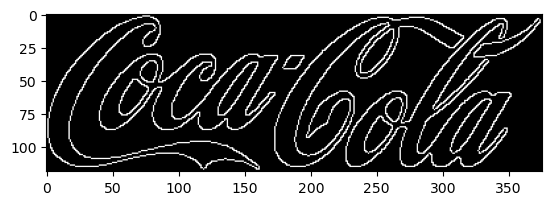

In [139]:
# Cargamos el template
template_path = 'template/pattern.png'
template = cv.imread(template_path)
blur_template = prepare_template(template, remove_padding=True)
plt.figure()
plt.imshow(blur_template, cmap='gray')
plt.show()


In [140]:
#Redimensionamos la imagen pasada como parametros por ancho o alto, manteniendo el ratio
def resize(image: np.ndarray, scale:float, width = None, height = None, inter = cv.INTER_AREA, apply_direct=False) -> np.ndarray:
	
	resized_img = copy.deepcopy(image)

	if (apply_direct):
		resized_img = cv.resize(resized_img, None, fx=scale,fy=scale)
	else:
		(h, w) = image.shape[:2]
		if scale > 1 : # Es una ampliacion usamos cubic
			inter = cv.INTER_LANCZOS4
		else:
			inter = cv.INTER_AREA

		w_scaled =int(w * scale)
		h_scaled =int(h * scale)
		if w_scaled > 0 and h_scaled > 0:
			resized_img = cv.resize(resized_img, (w_scaled,h_scaled), interpolation = inter)
		else:
			resized_img = image
	return resized_img

In [141]:
#Preparamos ahora la imagen 
def prepare_image (img:np.ndarray, main_canny:bool =False, initial_blur=True) -> np.ndarray:
    '''Prepara la imagen para el procesamiento'''
    #Aplicamos desenfoque Gausseano para disminuir el ruido de la imagen 
    blur_image = copy.deepcopy(img)

    if (initial_blur):
        blur_image = cv.GaussianBlur(blur_image,(5,5),0)
    
    
    blur_image = cv.cvtColor(blur_image, cv.COLOR_BGR2GRAY)

   
    if (main_canny):
        blur_image = cv.Canny(blur_image, 150, 200, L2gradient=True)
   

    return blur_image

In [142]:
# Definimos otra función para hacer un post tratamiento luego del resize
def prepare_scaled (scaled:np.ndarray) -> np.ndarray:
    '''Prepara el template escalado para el procesamiento'''

    scaled = cv.Canny(scaled, 50, 200, L2gradient=True)
                              
    return scaled

Con las funciones auxiliares creadas generamos el método *detect_pattern_in_image_single* para detectar el logo en cada imagen:

In [143]:
def detect_pattern_in_image_single(img:np.ndarray, pattern:np.ndarray, method:str='cv.TM_CCORR_NORMED', color:tuple=(0, 255, 0)) -> dict :
    '''Devuelve la imagen con un rectángulo donde detectó el patrón (Simple)'''

    response = [] #La respuesta está pensanda para devolver 1 rta para cada método por si se quiere hacer un análisis de que método de template matching aplica mejor

    #Imagen donde encontrar el template    
    blur_image = prepare_image(img, main_canny=True)
    
    #Patrón a encontrar
    blur_template = prepare_template(pattern,main_canny=True,initial_resize=True,remove_padding = True)
    (tH, tW) = blur_template.shape[:2]

    best_found = None
    img_method = copy.deepcopy(img)

    for scale in np.linspace(0.05,3, 40)[::-1]:

        #Escalamos la imagen
        resized = resize(blur_image, scale, apply_direct=True)

        #Preparamos la imagen luego del resize
        resized = prepare_scaled(resized)
        
        #Si el template quedó más grande que la imagen omitimos esto ya que no es válido
        if blur_template.shape[0] > resized.shape[0] or blur_template.shape[1] > resized.shape[1]:
            continue

        
        #Aplicar Template Matching y guardar el mejor valore entre las distintas iteraciones de escalado
        result = cv.matchTemplate(resized, blur_template, eval(method))
        (minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(result)
        
        if best_found is None or (maxVal > best_found[0]) :
            best_found = (maxVal, maxLoc, scale)
    

    #Solo se crea el rectángulo con el mejor matching encontrado
    if not best_found is None:
        (maxVal, maxLoc,matched_scale) = best_found
        (startX, startY) = (int(maxLoc[0] /matched_scale ), int(maxLoc[1]/matched_scale ))
        (endX, endY) = (int((maxLoc[0] + tW)/matched_scale) , int((maxLoc[1] + tH) /matched_scale ))
        cv.rectangle(img_method, (startX, startY), (endX, endY), color, int(2))
        cv.putText(img_method, f'{maxVal:.2f}', (startX, startY - int(10*matched_scale)), cv.FONT_HERSHEY_SIMPLEX, 1/ matched_scale, color, int(2))

        #response[method] = img_method
        response = img_method
            
    return response

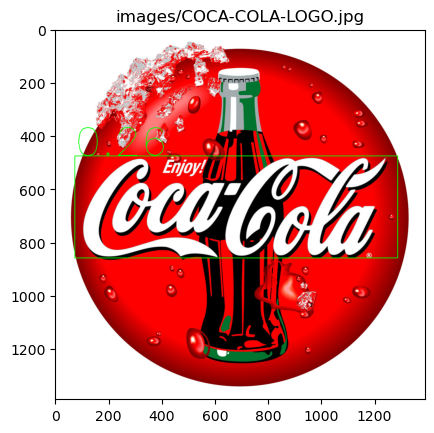

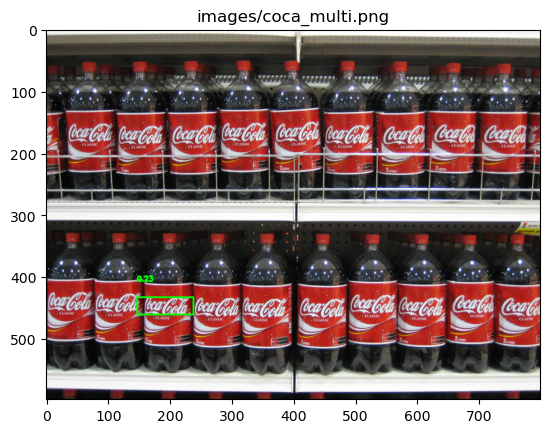

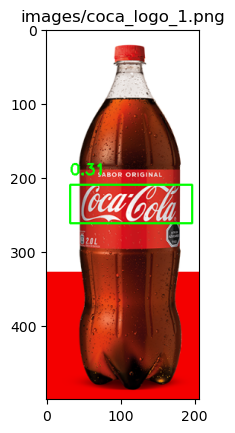

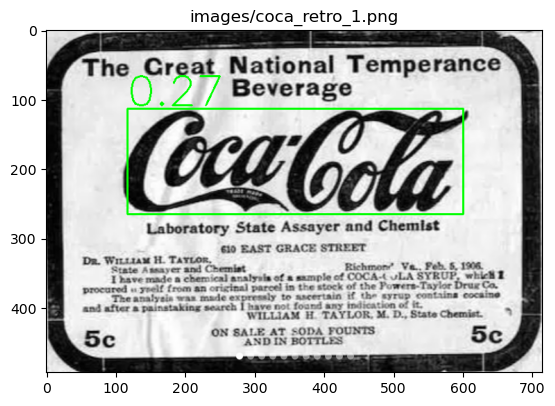

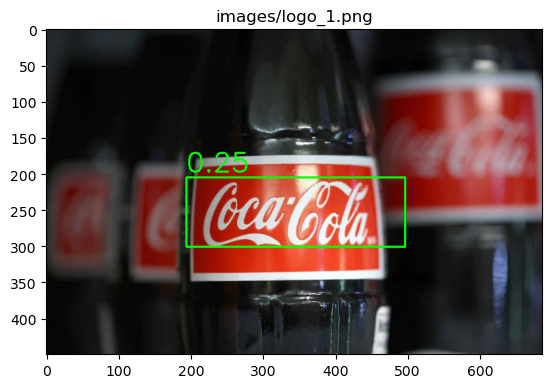

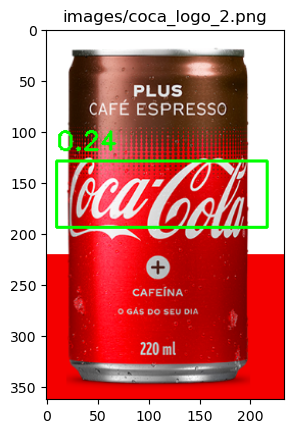

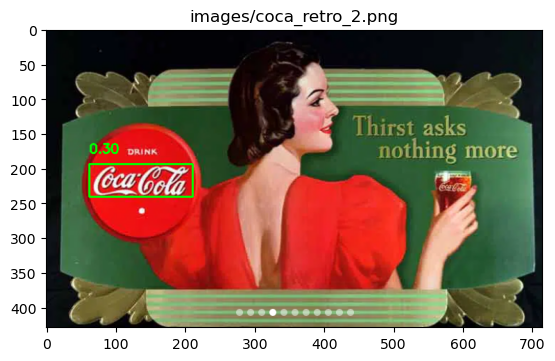

In [144]:
# Mostramos los resultados
for ix,image_path in enumerate(get_files('images')):
    image = detect_pattern_in_image_single(cv.imread(image_path), template)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.figure()
    plt.title(image_path)
    plt.imshow(image_rgb)
    plt.show()

    

**Comentarios parte 1**

* Finalmente logramos buenos y mejores resultados modificando el tamaño de la imagen donde buscamos el logo en lugar de modificar el tamaño del template.
* El método final de búsqueda es fuertemente dependiente de los hiperparámetros y del orden en que se hacen los tratamientos en la imagen. 
* Encontramos los mejores resultados con una técnica interesante, aplicamos canny a la imagen, luego hicimos el resize y por último volvimos a aplicar Canny. Esto nos permitió suavizar Canny para cada escala, sin haber perdido tanta definición en el resize.
* Los valores de *confianza* resultan bajos en las diferentes imágenes.

Como el algoritmo final lo sentimos muy refinado para que funcione en las imagenes, nos propusimos la idea de "testear" el algoritmo con otras imágenes de similares características y ver como funciona.

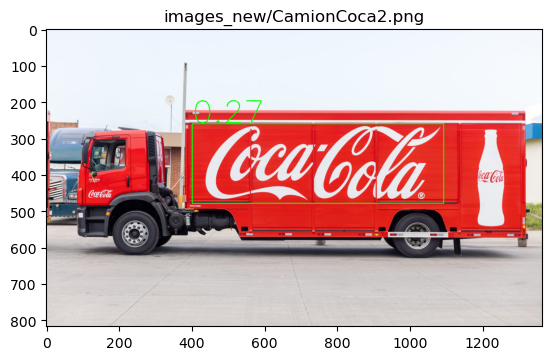

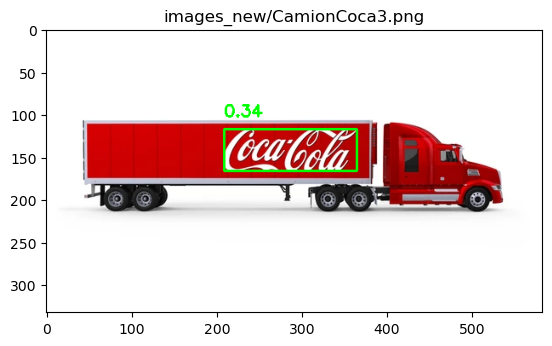

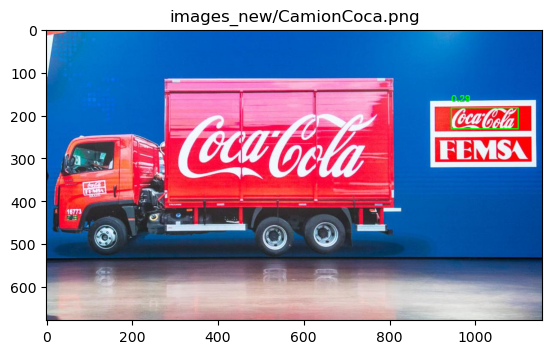

In [145]:
# Mostramos los nuevos resultados
for ix,image_path in enumerate(get_files('images_new')):
    image = detect_pattern_in_image_single(cv.imread(image_path), template)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.figure()
    plt.title(image_path)
    plt.imshow(image_rgb)
    plt.show()

Podemos observar que el modelo termina teniendo buenos resultados en general, y si bien en el primer caso no encuentra el logo más grande, si logra detectar un logo a la perfección.

De esta manera, podemos asegurar que llegamos a encontrar un algoritmo que logra encontrar los logos de Coca-Cola en diferentes imágenes.

## Detección Múltiple

Para la detección múltiple hubo que modificar la idea de la parte 1, en este caso, hacemos el resize del template y no de la imagen.

Más allá de esa diferencia el razonamiento es el mismo que antes.

In [146]:
# Función auxiliar para eliminar múltiples coincidencias de la misma detección
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

In [147]:
def detect_pattern_in_image_multi(img:np.ndarray, pattern:np.ndarray, method:str='cv.TM_CCOEFF_NORMED', color:tuple=(255, 0, 0), threshold:float = 0.19) -> dict :
    '''Devuelve la imagen con un rectángulo donde detectó el patrón (múltiple)'''

    response = [] #La respuesta está pensanda para devolver 1 rta para cada método por si se quiere hacer un análisis de que método de template matching aplica mejor

    #Imagen donde encontrar el template    
    blur_image = prepare_image(img)
    
    #Patrón a encontrar
    blur_template = prepare_template(pattern)
    (tH, tW) = pattern.shape[:2]

    best_found = None
    img_method = copy.deepcopy(img)

    all_results = []
    for scale in np.linspace(0.2,3, 40)[::-1]:
        r = scale

        scale_results = []

        #Escalar template ya que no tienen el mismo tamaño del objeto a encontar
        resized = resize(blur_template, scale, inter=cv.INTER_LANCZOS4)
        
        
        #Si el template quedó más grande que la imagen omitimos esto ya que no es válido
        if resized.shape[0] > img.shape[0] or resized.shape[1] > img.shape[1]:
            continue

        
        #Aplicar Template Matching y guardar el mejor valore entre las distintas iteraciones de escalado
        result = cv.matchTemplate(blur_image, resized, eval(method))
        (minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(result)
            
            
        loc = np.where(result >= threshold)
        for pt in zip(*loc[::-1]):
            scale_results.append((pt, r, result[pt[1], pt[0]]))

        img_method_test = copy.deepcopy(blur_image)
        for pt, r, _ in scale_results:
            cv.rectangle(img_method_test, pt, (int(pt[0] + tW * r), int(pt[1] + tH * r)), color, 2)
            cv.putText(img_method_test, f'{maxVal:.2f}', (int(pt[0] + tW * r), int(pt[1] + tH * r) - 10), cv.FONT_HERSHEY_SIMPLEX, 2, color, 2)

        if len(scale_results) > 0:
            all_results = scale_results

        all_results = [res for res in all_results if res[2] >= threshold]

    # Aplicar Non-Maximum Suppression para eliminar vecinos cercanos
    boxes = []
    for pt, r, score in all_results:
        boxes.append([pt[0], pt[1], int(pt[0] + tW * r), int(pt[1] + tH * r), score])
    boxes = np.array(boxes)
    
    if len(boxes) > 0:
        boxes = non_max_suppression(boxes, overlapThresh=0.3)
    
    for (startX, startY, endX, endY, _) in boxes:
        cv.rectangle(img_method, (startX, startY), (endX, endY), color, 2)
        cv.putText(img_method, f'{maxVal:.2f}', (startX, startY - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    response = img_method
            
    return response

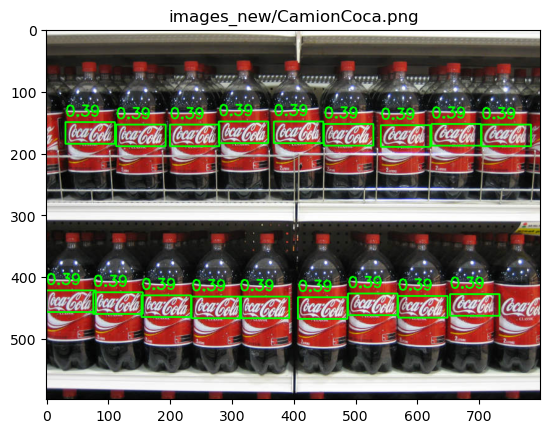

In [148]:
# Chequeamos los resultados
coca_cola_multi_path = 'images/coca_multi.png'
coca_cola_multi = cv.imread(coca_cola_multi_path)

template_path = 'template/pattern.png'
template = cv.imread(template_path)

image = detect_pattern_in_image_multi(coca_cola_multi, template,threshold=0.35, color=(0,255,0))
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.figure()
plt.title(image_path)
plt.imshow(image_rgb)
plt.show()

De esta manera encontramos todas las instancias del logo en la imagen, con la particularidad de que la escala en cada caso debe ser la misma.

## Conclusiones Finales

* Este TP nos hizo probar y estudiar como se comportaban todos los diferentes tipos de algoritmos de detección de borde y como se veian modificados con los cambios de hiperparámetros. Esto nos ayudará en un futuro a imaginar cuales son las mejoras técnicas de búsqueda de borde.
* Este TP requería re escalar las imagenes y el template, lo que similar al caso anterior, nos permite observar los beneficios y desventajas de tener que hacer un rescalado.
* Si bien los métodos no normalizados funcionan adecuadamente, es díficil determinar un nivel de confianza de la detección.
* El debe más grande que nos deja este TP es no haber logrado usar la misma idea para el algoritmo en casos particulares y en el caso múltiple, y sería lo que tendríamos que lograr para generalizar el método.